<h4>Load in the data and libraries<h4>

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'german_influence.ipynb', 'german_influence_copy.ipynb', 'influence.py', 'load_dataset.py', 'loss.py', 'metrics.py', 'random_influence.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


In [3]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('PINCP')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['PINCP'] = changed_df_labels

    return y_predicted


<h3>Removal Based Influence Calculation<h3>

In [4]:
#List of time taken
sol_time = []

In [5]:
dataset = 'acsincome'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [6]:
X_train, X_test, y_train, y_test = load(dataset)

In [7]:
X_train = X_train.drop(columns=['RAC1P_white','RAC1P_poc','AGEP_old','AGEP_young','SEX_female','POBP'],axis=1)
X_test= X_test.drop(columns=['RAC1P_white','RAC1P_poc','AGEP_old','AGEP_young','SEX_female','POBP'],axis=1)

In [8]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [9]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
predictors = ['WKHP', 'ST', 'COW_gov', 'COW_no_income', 'COW_non-profit',
       'COW_private_business', 'COW_self_employed', 'MAR_divorced',
       'MAR_married', 'MAR_never_married', 'MAR_seperated', 'MAR_widowed',
       'SEX_male', 'SCHL_BD', 'SCHL_GS', 'SCHL_HE', 'OCCP_business',
       'OCCP_infrastructure', 'OCCP_life', 'OCCP_military', 'OCCP_sales',
       'OCCP_stem', 'RELP_family', 'RELP_non-family']
target_var = ['PINCP']

In [11]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [12]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [13]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.12061127265223165
Initial TPR parity:  -0.09563587043402111
Initial predictive parity:  -0.13304342999011864
Initial accuracy:  0.7425


<h5>INF Calc on Original Labels for LOO<h5>

In [14]:
if_start = time.time()
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [15]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 6400/6400 [01:20<00:00, 79.61it/s]


In [16]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [17]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [18]:
#multiple the inverse by -1
negative_hinv_v = -1 * hinv_v

In [19]:
inf = np.matmul(np.transpose(negative_hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [20]:
inf = (-1/(len(X_train))) * inf

In [21]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]

<h5>Leave One out Trainng<h5>

In [22]:
#Removal using leave one out concept
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

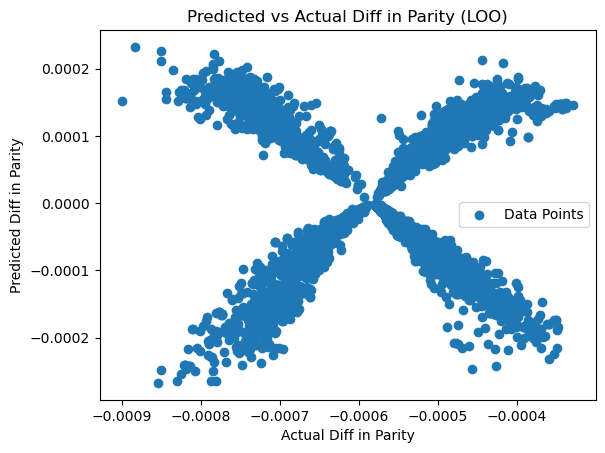

In [23]:
predicted_diff = decimal_array
#actual_diff = actual_parity_list
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (LOO)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h4>Calculate Influence of the datapoints after flipping them<h4>

In [24]:
flipping_time_start = time.time()
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})

In [25]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [26]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_1)

predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_1)

accuracy_1 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_1)

Initial statistical parity:  0.12135847464861826
Initial TPR parity:  0.09654880362331392
Initial predictive parity:  -0.10513581557676593
Initial accuracy:  0.256875


In [27]:
#Original datapoints before changing the datapoints
metric_val = [spd_1, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta_2 = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [28]:
hessian_all_points_2 = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 6400/6400 [01:20<00:00, 79.61it/s]


In [29]:
del_L_del_theta_2 = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [30]:
hinv_v_2, hinv_2 = get_hinv_v(hessian_all_points_2, np.transpose(del_L_del_theta_2))
#incorporate del_l_del_theta_i with the updated datapoint

In [31]:
#Get the negative of the inverse hessian
negative_hinv_v_2 = -1*hinv_v_2

In [32]:
inf2 = np.matmul(np.transpose(negative_hinv_v_2), del_F_del_theta_2)
#For the new datapoint re-calculate the hinv_v

In [33]:
inf2 = (-1/(len(X_train))) * inf2

In [34]:
#first timer end
flipping_end_time = time.time() - flipping_time_start

In [35]:
#Flipping
#Make the original flips to test for the parity after each flip 
actual_df_train = train_full_df.copy()
actual_parity_list = []

for index, row in actual_df_train.iterrows():
    if row['PINCP'] == 1:
        #Flip the label at income = 1 to 0
        actual_df_train.at[index,'PINCP'] = 0
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'PINCP'] = 1
        
    elif row['PINCP'] == 0:
        actual_df_train.at[index,'PINCP'] = 1
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'PINCP'] = 0

In [36]:
decimal_array = [format(num, '.10f') for num in inf2]
decimal_array = [float(num) for num in decimal_array]

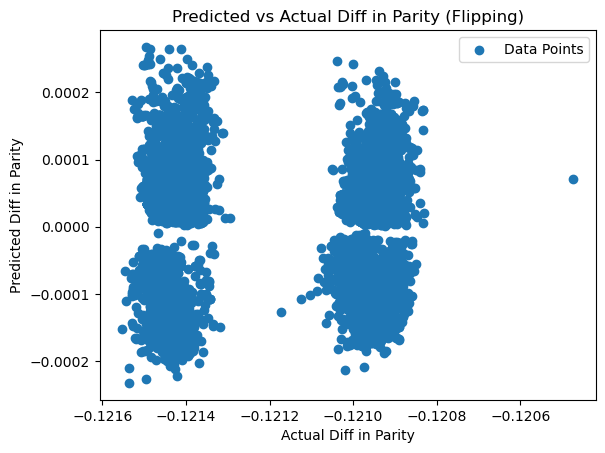

In [37]:
predicted_diff = decimal_array
actual_diff = actual_parity_list

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<h5>Implement Solutions<h5>
<li>Influence</li>
<li>Entropy</li>
<li>Randomized</li>


<h5>Influence Based Flips<h5>

In [38]:
if_start = time.time()
index_list = []
for i in range(len(X_train)):
    index_list.append(i)

In [39]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [40]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(inf2, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
if_end = time.time()
if_time2 = if_end-if_start
if_time2 += flipping_end_time
print(if_time2)

83.92929244041443


In [41]:
if if_time2 < 0:
    if_time2 = -1 * if_time2
else: 
    pass

In [42]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'PINCP'] == 1:
        influence_train_copy.at[row_num,'PINCP'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'PINCP'] == 0:
        influence_train_copy.at[row_num,'PINCP'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)

In [43]:
sol_time.append(if_time2)

<h5>Uncertainty Reduction/Entropy<h5>

In [44]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [45]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

75.0


In [46]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [47]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [48]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time()

In [1]:
entropy_train_df['PINCP'] = entropy_train_df['PINCP'].astype('int')

NameError: name 'entropy_train_df' is not defined

In [50]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [51]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'PINCP'] == 0:
        entropy_train_df.at[row_num,'PINCP'] = 1
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'PINCP'] == 1:
        entropy_train_df.at[row_num,'PINCP'] = 0
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [52]:
entropy_time = entropy_end - entropy_start
sol_time.append(entropy_time)

<h5>Randomized<h5>

In [53]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [54]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = len(y_test)

for iter in range(budget):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'PINCP'] == 1:
        random_training_df.at[random_row,'PINCP'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'PINCP'] == 0:
        random_training_df.at[random_row,'PINCP'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()


In [55]:
random_time = random_end - random_start
sol_time.append(random_time)

<h5>Graph Time and Parity<h5>

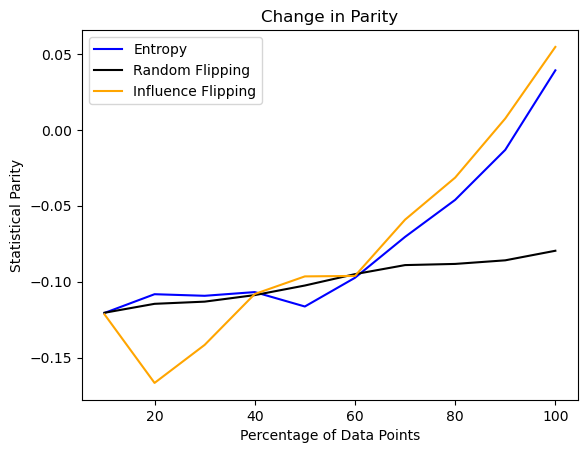

In [56]:
# Calculate the total number of data points
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_entropy = [int(i * datapoints_entropy / 10) for i in range(0, 10)]
indices_random = [int(i * datapoints_random / 10) for i in range(0, 10)]
indices_influence = [int(i * datapoints_influence / 10) for i in range(0, 10)]

# Extract the values at these indices
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_random, label='Random Flipping', color='Black')
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_influence, label='Influence Flipping', color='Orange')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()

<h4>Time Comparisons<h4>

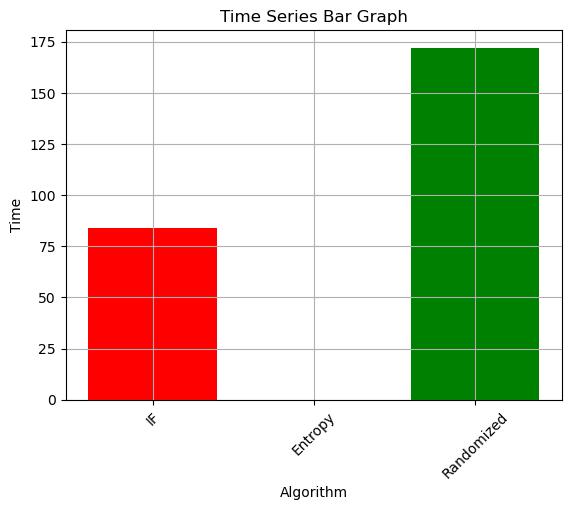

In [57]:
# Create a line chart
x_axis = ['IF', 'Entropy', 'Randomized']
# Colors for each bar
colors = ['red', 'blue', 'green']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Series Bar Graph')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [58]:
print(predicted_diff)
print(actual_diff)
print(sol_time)

[7.15913e-05, 1.4902e-05, -0.0001221335, -0.000143932, -0.0001130434, 1.97429e-05, 4.78283e-05, 7.06442e-05, 4.14359e-05, -7.44709e-05, 3.38041e-05, 6.32335e-05, -5.44723e-05, 0.0001409566, 3.63765e-05, -0.0001274268, 1.6293e-05, 1.07824e-05, 1.85474e-05, 4.71876e-05, 5.86456e-05, 5.7192e-05, 4.66134e-05, 3.04614e-05, 6.05765e-05, -3.32752e-05, -9.57945e-05, -0.0001475695, 3.39708e-05, 4.80373e-05, -0.0001741053, 6.6839e-06, -0.0001041684, 6.56249e-05, -0.0001469514, 7.8788e-06, 2.2736e-05, 0.0002033937, -0.0001868285, -0.0001387591, -0.0001366831, -6.91787e-05, -0.0001433358, -6.53144e-05, -6.17596e-05, 3.33051e-05, 0.0001852267, 7.78415e-05, -0.0001870896, -0.0001038384, 9.4085e-06, 6.3199e-06, -0.0001430328, 0.00016997, 5.96839e-05, -0.0001769707, 4.30337e-05, 0.0001507309, -9.70225e-05, 3.34717e-05, -0.0001337004, 7.83394e-05, -0.0001783781, 0.0002070776, -0.0001631167, 0.0001803598, -6.57673e-05, 0.0002164533, 4.44964e-05, 4.86184e-05, 9.46988e-05, -8.32869e-05, 6.01333e-05, 1.725

In [59]:

# Finding indices where Y (actual_diff) is positive and X (predicted_diff) is negative
positive_Y_negative_X = [index for index, (x, y) in enumerate(zip(predicted_diff, actual_diff)) if y > 0 and x < 0]

# Finding indices where Y (actual_diff) is negative and X (predicted_diff) is positive
negative_Y_positive_X = [index for index, (x, y) in enumerate(zip(predicted_diff, actual_diff)) if y < 0 and x > 0]

print("Indices where Y is positive and X is negative:", positive_Y_negative_X)
print("Indices where Y is negative and X is positive:", negative_Y_positive_X)

Indices where Y is positive and X is negative: []
Indices where Y is negative and X is positive: [0, 1, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 31, 33, 35, 36, 37, 45, 46, 47, 50, 51, 53, 54, 56, 57, 59, 61, 63, 65, 67, 68, 69, 70, 72, 73, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 88, 90, 92, 93, 94, 95, 96, 100, 102, 104, 105, 108, 109, 110, 111, 113, 116, 117, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 142, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 161, 162, 163, 166, 168, 170, 172, 176, 177, 178, 179, 182, 183, 184, 186, 190, 191, 192, 193, 194, 195, 196, 197, 200, 202, 204, 208, 209, 210, 211, 213, 214, 215, 217, 218, 220, 221, 223, 224, 225, 227, 228, 236, 237, 238, 239, 244, 245, 246, 248, 250, 251, 252, 253, 255, 256, 258, 260, 261, 262, 265, 268, 269, 271, 272, 274, 276, 277, 278, 279, 281, 282, 284, 285, 286, 287, 288, 290, 291, 293, 294, 295, 296, 297, 298, 299, 300, 302, 

In [60]:
# Pull rows corresponding to indices in positive_Y_negative_X
df_positive_Y_negative_X = X_train_orig.loc[positive_Y_negative_X]

# Pull rows corresponding to indices in negative_Y_positive_X
df_negative_Y_positive_X = X_train_orig.loc[negative_Y_positive_X]

# Optionally, you can combine these two dataframes into one
df_combined = pd.concat([df_positive_Y_negative_X, df_negative_Y_positive_X])

#print("Rows where Y is positive and X is negative:")
#print(df_positive_Y_negative_X)

#print("\nRows where Y is negative and X is positive:")
#print(df_negative_Y_positive_X)

print("\nCombined Dataframe:")
df_combined


Combined Dataframe:


,WKHP,ST,COW_gov,COW_no_income,COW_non-profit,COW_private_business,COW_self_employed,MAR_divorced,MAR_married,MAR_never_married,...,SCHL_GS,SCHL_HE,OCCP_business,OCCP_infrastructure,OCCP_life,OCCP_military,OCCP_sales,OCCP_stem,RELP_family,RELP_non-family
0,40.0,12.0,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,40.0,6.0,False,False,False,True,False,False,False,True,...,True,False,False,False,False,False,True,False,False,True
5,40.0,16.0,False,False,False,True,False,False,False,True,...,True,False,False,True,False,False,False,False,False,True
6,45.0,12.0,False,False,False,True,False,False,False,True,...,True,False,True,False,False,False,False,False,False,True
7,50.0,22.0,False,False,False,True,False,False,True,False,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6390,35.0,36.0,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
6392,50.0,42.0,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
6393,8.0,42.0,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False
6395,34.0,37.0,False,False,False,True,False,False,True,False,...,True,False,False,True,False,False,False,False,True,False
